In [82]:
# Firstly we get some 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
# Here we load up our data into a pandas dataframe
data = pd.read_csv('/Users/kecichilala/Downloads/archive/individual_stocks_5yr/individual_stocks_5yr/AMZN_data.csv')

data
# I don't care about all the columns basically
# That's why in the cell below I created a dataframe with cells I do care about

,date,open,high,low,close,volume,Name
0,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
1,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
2,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
3,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
4,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN
...,...,...,...,...,...,...,...
1254,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808,AMZN
1255,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722,AMZN
1256,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985,AMZN
1257,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819,AMZN


In [83]:
# Here I created a subset with the columns I want to work with
data = data[['date', 'close']]

data

,date,close
0,2013-02-08,261.95
1,2013-02-11,257.21
2,2013-02-12,258.70
3,2013-02-13,269.47
4,2013-02-14,269.24
...,...,...
1254,2018-02-01,1390.00
1255,2018-02-02,1429.95
1256,2018-02-05,1390.00
1257,2018-02-06,1442.84


In [84]:
# On pytorch by default it's going to use CPU
# But I want to use GPU so that's what the code below does
device = 'cuda: 0 ' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/var/folders/5f/ttqm_dp90cv1qr1xm29zwjd80000gn/T/ipykernel_79846/3507580475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


Text(0, 0.5, 'close prices')

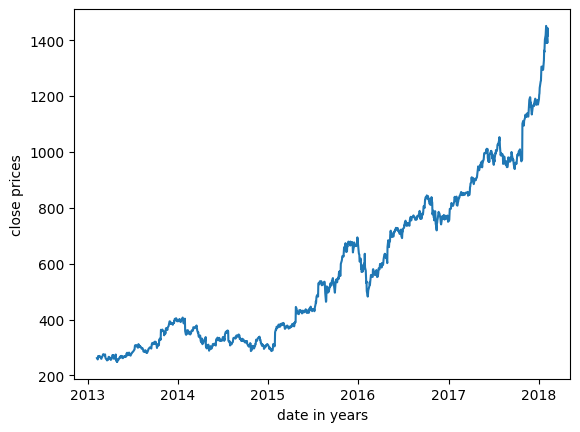

In [85]:
# Now we are going to do some simple transformation
# We make the date column a pandas date type 
data['date'] = pd.to_datetime(data['date'])

# This makes a plot of the date in the x - axis
# And a plot of the close price in the y - axis 
plt.plot(data['date'], data['close'])

# I Add labels to the axes for clarity
plt.xlabel('date in years')
plt.ylabel('close prices')

In [86]:
# Now I want to set up the data frame in a way
# That's close that how the model will take the input

from copy import deepcopy as dc

# This function prepares a data frame for LSTM
# The reason we do this is to train the model to predict to closing price 
# based on the prices of the last week (that's why we keep our lookback variable on 7)
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'close(t-{i})'] = df['close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7 #we stick to (week) 7 because it's more logical for the model
# The reason this modele likes this is because now we have a input and output pair
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
date,,,,,,,,
2013-02-20,266.41,269.75,265.09,269.24,269.47,258.70,257.21,261.95
2013-02-21,265.94,266.41,269.75,265.09,269.24,269.47,258.70,257.21
2013-02-22,265.42,265.94,266.41,269.75,265.09,269.24,269.47,258.70
2013-02-25,259.87,265.42,265.94,266.41,269.75,265.09,269.24,269.47
2013-02-26,259.36,259.87,265.42,265.94,266.41,269.75,265.09,269.24
...,...,...,...,...,...,...,...,...
2018-02-01,1390.00,1450.89,1437.82,1417.68,1402.05,1377.95,1357.51,1362.54
2018-02-02,1429.95,1390.00,1450.89,1437.82,1417.68,1402.05,1377.95,1357.51
2018-02-05,1390.00,1429.95,1390.00,1450.89,1437.82,1417.68,1402.05,1377.95


In [87]:
# now we have that data frame we convert the data frame to numpy 

shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 266.41,  269.75,  265.09, ...,  258.7 ,  257.21,  261.95],
       [ 265.94,  266.41,  269.75, ...,  269.47,  258.7 ,  257.21],
       [ 265.42,  265.94,  266.41, ...,  269.24,  269.47,  258.7 ],
       ...,
       [1390.  , 1429.95, 1390.  , ..., 1417.68, 1402.05, 1377.95],
       [1442.84, 1390.  , 1429.95, ..., 1437.82, 1417.68, 1402.05],
       [1416.78, 1442.84, 1390.  , ..., 1450.89, 1437.82, 1417.68]])

In [88]:
from sklearn.preprocessing import MinMaxScaler
# Now we run a scaler on all the data 
scaler = MinMaxScaler(feature_range=(-1, 1))
# Here we override the matrix we have above 
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np


array([[-0.96976702, -0.96421266, -0.97196215, ..., -0.9825886 ,
        -0.98490236, -0.97653598],
       [-0.97054862, -0.96976702, -0.96421266, ..., -0.9646783 ,
        -0.9823973 , -0.98464235],
       [-0.97141337, -0.97054862, -0.96976702, ..., -0.96506078,
        -0.96429022, -0.98209415],
       ...,
       [ 0.89874112,  0.96517719,  0.89874112, ...,  0.94477242,
         0.93986163,  0.93205353],
       [ 0.98661301,  0.89874112,  0.96517719, ...,  0.97826485,
         0.96613959,  0.97326949],
       [ 0.94327574,  0.98661301,  0.89874112, ...,  1.        ,
         1.        ,  1.        ]])

In [89]:
# Now that our data is scaled I am going to make it x and y
x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape

((1252, 7), (1252,))

In [90]:
# We mirrored the data frame above
# Because for an LSTM I want it rerepeatedly to get the updated answer
# Until it gets to the close to updated answer there is 
x = dc(np.flip(x, axis=1))
x

array([[-0.97653598, -0.98490236, -0.9825886 , ..., -0.96506078,
        -0.97196215, -0.96421266],
       [-0.98464235, -0.9823973 , -0.9646783 , ..., -0.97196215,
        -0.96421266, -0.96976702],
       [-0.98209415, -0.96429022, -0.96506078, ..., -0.96421266,
        -0.96976702, -0.97054862],
       ...,
       [ 0.93205353,  0.93986163,  0.94477242, ...,  1.        ,
         0.89874112,  0.96517719],
       [ 0.97326949,  0.96613959,  0.97826485, ...,  0.89874112,
         0.96517719,  0.89874112],
       [ 1.        ,  1.        ,  1.        , ...,  0.96517719,
         0.89874112,  0.98661301]])

In [91]:
# Now we are going to split the data in to train and Test 
# Using the split method

split_index = int(len(x)* 0.95)

split_index 

x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1189, 7), (63, 7), (1189,), (63,))

In [92]:
# For pytorch LSTM is required to have a extra dimension at the end
# so we reshape all of these things 

x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1189, 7, 1), (63, 7, 1), (1189, 1), (63, 1))

In [93]:
# Now we are putting this into Pytorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [94]:
# When training models in pytorch we use datasets instead of raw pytorch
# That's why i made my own costum class

from torch.utils.data import Dataset

class timeseriesdataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    

train_dataset = timeseriesdataset(x_train, y_train)
test_dataset = timeseriesdataset(x_test, y_test)

In [95]:
# we also save the datasets in DataLoader
# we iterator of the loaders, get batches and make updates for our model
from torch.utils.data import DataLoader

batchsize = 16 
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [96]:
# For visualisation this is quite helpfull to do
# 
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [98]:
#

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
#
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _= self.lstm(x, (h0, c0))
        out = self. fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
 

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [102]:
#This creates the training fucntion 
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: # prints every 100 batches 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
    print() 
            

In [105]:
# Now we create validate function 

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss
    
    agv_loss_across_batches = running_loss / len(test_loader)

    print('Val loss: {0:.3f}'.format(agv_loss_across_batches))
    print('*******')
    print( )


In [109]:
# Now we are coding a training loop 
# Play around with the learning rate, Batchsize, model arcitecture  
learning_rate = 0.001
num_epochs = 10 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val loss: 0.023
*******

Epoch: 2

Val loss: 0.024
*******

Epoch: 3

Val loss: 0.024
*******

Epoch: 4

Val loss: 0.024
*******

Epoch: 5

Val loss: 0.021
*******

Epoch: 6

Val loss: 0.020
*******

Epoch: 7

Val loss: 0.020
*******

Epoch: 8

Val loss: 0.020
*******

Epoch: 9

Val loss: 0.019
*******

Epoch: 10

Val loss: 0.021
*******



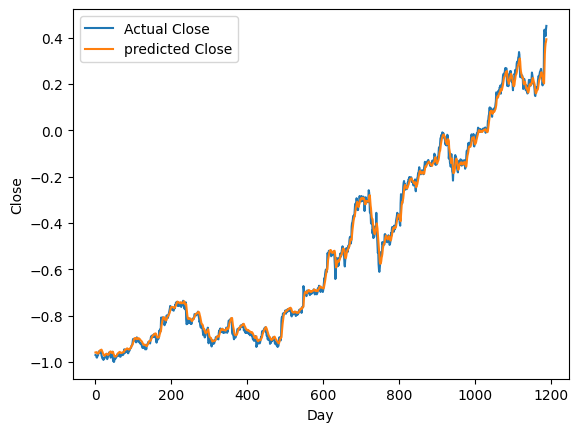

In [116]:
#This is some code to do some plottings

with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label= 'Actual Close')
plt.plot(predicted, label ='predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [117]:
# I made a matrix that made a shape that
train_predictions = predicted.flatten()

# this code adjust the proper shape 
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 272.81206251,  273.14453347,  273.47327686, ..., 1076.06053561,
       1079.23789848, 1086.04677897])

In [118]:


# this code adjust the proper shape 
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 266.40998941,  265.93999247,  265.41999584, ..., 1094.22000544,
       1111.60000005, 1120.65999495])

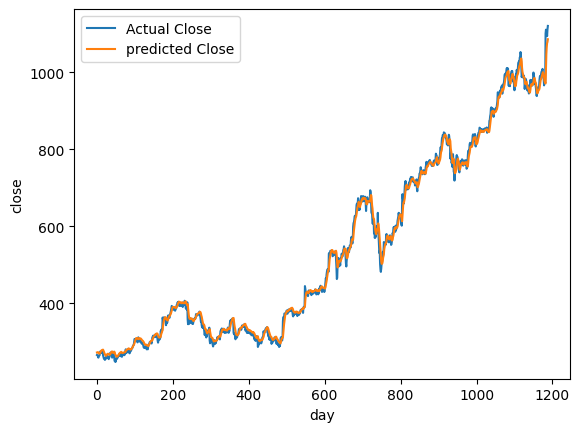

In [122]:
#This is some code to do some plottings

plt.plot(new_y_train, label= 'Actual Close')
plt.plot(train_predictions, label ='predicted Close')
plt.xlabel('day')
plt.ylabel('close')
plt.legend()
plt.show()

In [127]:
# Predictions are made using the trained model on the test data, 
# and the results are detached from the computation graph, moved to CPU, and converted to NumPy array.
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

# Create a matrix of zeros with dimensions (number of test samples, lookback + 1).
dummies = np.zeros((x_test.shape[0], lookback + 1))

# Set the first column of the 'dummies' matrix to be the test predictions.
dummies[:, 0] = test_predictions

# Inverse transform the 'dummies' matrix back to the original scale using the scaler that was used for preprocessing.
dummies = scaler.inverse_transform(dummies)

# Extract the first column of the transformed matrix (which corresponds to the predicted values after inverse transformation).
test_predictions = dummies[:, 0]

# Display or use the test predictions as needed in the variable 'test_predictions'.
# Note: 'dc' seems to be a function or variable not defined in the provided code.
# If 'dc' is a function, it might be used to further process the predictions.
test_predictions = dc(dummies[:, 0])
test_predictions


array([1092.77429799, 1096.67463107, 1101.98068978, 1104.30712628,
       1104.64647892, 1105.93715154, 1108.75591458, 1107.55441701,
       1109.80802244, 1109.03437156, 1107.5305462 , 1110.35436298,
       1116.83546783, 1129.07807646, 1139.44331378, 1145.29718255,
       1140.61355707, 1141.56799531, 1138.05479233, 1127.87134595,
       1123.0979361 , 1122.91725627, 1125.00129291, 1127.33031004,
       1130.67168618, 1131.90759213, 1132.62077746, 1135.64828467,
       1138.72629334, 1143.59418287, 1145.83613963, 1144.70413981,
       1143.23174794, 1140.53477622, 1140.88273095, 1142.48419008,
       1144.46141737, 1141.48462668, 1144.7561108 , 1150.63800807,
       1155.7155378 , 1163.59813892, 1172.56220255, 1179.35990032,
       1184.01650089, 1191.53021551, 1201.74634986, 1207.73340773,
       1209.396336  , 1210.06292665, 1210.65625613, 1217.13305993,
       1227.0088739 , 1231.77848449, 1238.14238579, 1245.73696011,
       1252.43150443, 1259.14784072, 1264.62500944, 1259.28930

In [128]:
# Create a matrix of zeros with dimensions (number of test samples, lookback + 1).
dummies = np.zeros((x_test.shape[0], lookback + 1))

# Set the first column of the 'dummies' matrix to be the actual test labels after flattening the y_test array.
dummies[:, 0] = y_test.flatten()

# Inverse transform the 'dummies' matrix back to the original scale using the scaler that was used for preprocessing.
dummies = scaler.inverse_transform(dummies)

# Extract the first column of the transformed matrix (which corresponds to the original values after inverse transformation).
# The result represents the test labels in their original scale.
new_y_test = dummies[:, 0]

# Apply the 'dc' function (assuming it's a defined function) to further process the new_y_test data if necessary.
new_y_test = dc(dummies[:, 0])

# Display or use the transformed test labels as needed in the variable 'new_y_test'.
# Note: Ensure that 'dc' function is defined and behaves as intended to avoid any errors.
new_y_test


array([1123.16999656, 1132.88000516, 1129.12999368, 1125.35000032,
       1129.16999342, 1136.83999736, 1126.68999162, 1137.28999443,
       1129.88000673, 1126.30999408, 1139.48999806, 1156.1600152 ,
       1186.00000055, 1195.83000837, 1193.59998701, 1161.27001785,
       1176.74998896, 1162.35001083, 1133.94999821, 1141.57000247,
       1152.35000412, 1159.78999162, 1162.0000131 , 1168.92000399,
       1165.07999309, 1164.12999927, 1174.26000514, 1179.14000927,
       1190.58000663, 1187.37999158, 1177.61998331, 1174.76000189,
       1168.36000763, 1176.75998889, 1182.259989  , 1186.0999999 ,
       1169.47000041, 1189.01001683, 1204.19998983, 1209.58999065,
       1229.14000701, 1246.86999934, 1252.69999731, 1254.32998672,
       1276.67998488, 1305.20001464, 1304.86001685, 1295.00000923,
       1293.3199843 , 1294.58001195, 1327.31001436, 1362.54000053,
       1357.50999737, 1377.95000794, 1402.04999473, 1417.68000071,
       1437.82001323, 1450.89      , 1390.00000133, 1429.94999

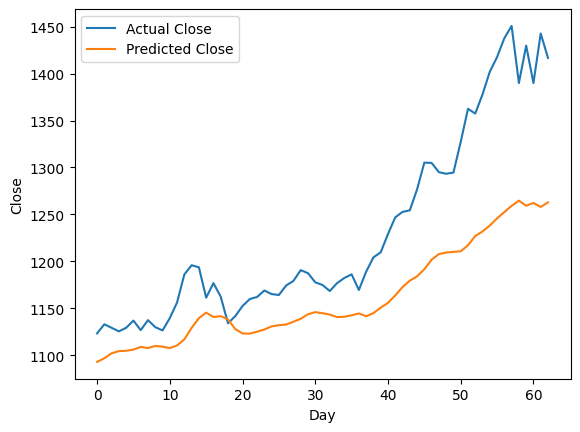

In [129]:
# Plot the actual close prices from the test dataset using a blue line.
plt.plot(new_y_test, label='Actual Close')

# Plot the predicted close prices generated by the model using an orange line.
plt.plot(test_predictions, label='Predicted Close')

# Label the x-axis of the plot as 'Day' to represent the timeline of the data points.
plt.xlabel('Day')

# Label the y-axis of the plot as 'Close' to represent the stock prices.
plt.ylabel('Close')

# Add a legend to the plot to distinguish between the actual and predicted close prices.
plt.legend()

# Display the plot, showing the actual and predicted close prices.
plt.show()
